# training lightgbm on the dataset

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split

In [2]:
# prepare the data
cutoff_dates = ['2015-01-01', '2016-01-01', '2017-01-01', '2018-01-01']
cutoff_dates = pd.to_datetime(cutoff_dates)
lgb_data_path = 'lgb_data/'

In [3]:
# hyper parameters
n_samples_list = [1000, 2000, 4000, 8000, 20000, 40000, 80000, 160000, 320000]
params = {
    'objective': 'binary',               # Binary classification
    'metric': 'binary_logloss',          # Metric for evaluation
    'boosting_type': 'gbdt',             # Gradient Boosting Decision Tree
    'num_leaves': 31,                    # Maximum number of leaves in one tree
    'max_depth': -1,                     # No limit on tree depth
    'learning_rate': 0.05,               # Step size shrinkage
    'feature_fraction': 0.8,             # Fraction of features to use per iteration
    'bagging_fraction': 0.8,             # Fraction of data to use per iteration
    'bagging_freq': 5,                   # Perform bagging every 5 iterations
    'min_data_in_leaf': 10,              # Minimum number of samples in a leaf
    'lambda_l1': 0.1,                    # L1 regularization
    'lambda_l2': 0.1,                    # L2 regularization
    'min_gain_to_split': 0.01,           # Minimum gain required to split
    'verbosity': -1,                      # Suppress output
    # number of trees
    'n_estimators': 1000,
}

In [4]:
from sklearn.metrics import roc_auc_score
import numpy as np
def train_model_and_get_rocauc(x_train, y_train, x_test, y_test, n_samples_train = 4000, params = params):
    if len(x_train) > n_samples_train:
        # sample the data
        samples = np.random.choice(len(x_train), n_samples_train, replace=False)
        x_train = x_train.loc[samples]
        y_train = y_train.loc[samples]
    train_data = lgb.Dataset(x_train, label=y_train)
    test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)
    # train the model
    model = lgb.train(params,
                      train_data,
                      num_boost_round=1000,
                      valid_sets=test_data)
    # get rocauc score
    y_pred = model.predict(x_test, num_iteration=model.best_iteration)
    rocauc = roc_auc_score(y_test, y_pred)
    miscal = np.mean(y_pred) - np.mean(y_test)
    # print(f"ROC AUC: {rocauc:.4f}, Miscalibration: {miscal:.4f}")
    return rocauc, miscal

### evaluate

In [5]:
rocaucs = {}
std = {}
miscals = {}
miscals_std = {}
for cutoff_date in cutoff_dates:
    rocaucs[cutoff_date] = {}
    std[cutoff_date] = {}
    miscals[cutoff_date] = {}
    miscals_std[cutoff_date] = {}
    x_train = pd.read_csv(lgb_data_path + 'lgb_x_train_' + cutoff_date.strftime('%Y%m%d') + '.csv')
    y_train = pd.read_csv(lgb_data_path + 'lgb_y_train_' + cutoff_date.strftime('%Y%m%d') + '.csv')
    x_test = pd.read_csv(lgb_data_path + 'lgb_x_test_' + cutoff_date.strftime('%Y%m%d') + '.csv')
    y_test = pd.read_csv(lgb_data_path + 'lgb_y_test_' + cutoff_date.strftime('%Y%m%d') + '.csv')
    for n_samples in n_samples_list:
        cur_rocauc = []
        cur_miscal = []
        for i in range(10):
            res = train_model_and_get_rocauc(x_train, y_train, x_test, y_test, n_samples_train = n_samples, params = params)
            cur_rocauc.append(res[0])
            cur_miscal.append(res[1])
        cur_std = np.std(cur_rocauc)
        cur_miscal_std = np.std(cur_miscal)
        rocaucs[cutoff_date][n_samples] = np.mean(cur_rocauc)
        std[cutoff_date][n_samples] = cur_std
        miscals[cutoff_date][n_samples] = np.mean(cur_miscal)
        miscals_std[cutoff_date][n_samples] = cur_miscal_std
        print(f"cutoff: {cutoff_date}, n_samples: {n_samples}, rocauc: {rocaucs[cutoff_date][n_samples]}, std: {std[cutoff_date][n_samples]}, miscal: {miscals[cutoff_date][n_samples]}, miscal_std: {miscals_std[cutoff_date][n_samples]}")

cutoff: 2015-01-01 00:00:00, n_samples: 1000, rocauc: 0.6054490591340927, std: 0.020794196682321502, miscal: -0.06740485166477006, miscal_std: 0.04207444237812757
cutoff: 2015-01-01 00:00:00, n_samples: 2000, rocauc: 0.6008468673871072, std: 0.021312414466962963, miscal: -0.08947813810835183, miscal_std: 0.016928690444869672
cutoff: 2015-01-01 00:00:00, n_samples: 4000, rocauc: 0.6098658260440121, std: 0.016295686588298837, miscal: -0.07935482901651919, miscal_std: 0.028380277900656902
cutoff: 2015-01-01 00:00:00, n_samples: 8000, rocauc: 0.6227100891763182, std: 0.023486674617177298, miscal: -0.06103346710059008, miscal_std: 0.01844701166549347
cutoff: 2015-01-01 00:00:00, n_samples: 20000, rocauc: 0.640173499734207, std: 0.01026561535899595, miscal: -0.036205754121743504, miscal_std: 0.00754139539767723
cutoff: 2015-01-01 00:00:00, n_samples: 40000, rocauc: 0.6532767681662539, std: 0.0038353257270626155, miscal: -0.028322060532747956, miscal_std: 0.006624112175993263
cutoff: 2015-01-

In [6]:
import matplotlib.pyplot as plt
import numpy as np

In [7]:
# pulled from colab runs
llm_results = {
    '320000': [0.681523,-0.04364],
    '80000': [0.673792,-0.028867],
    '20000': [0.657549,-0.05396],
}

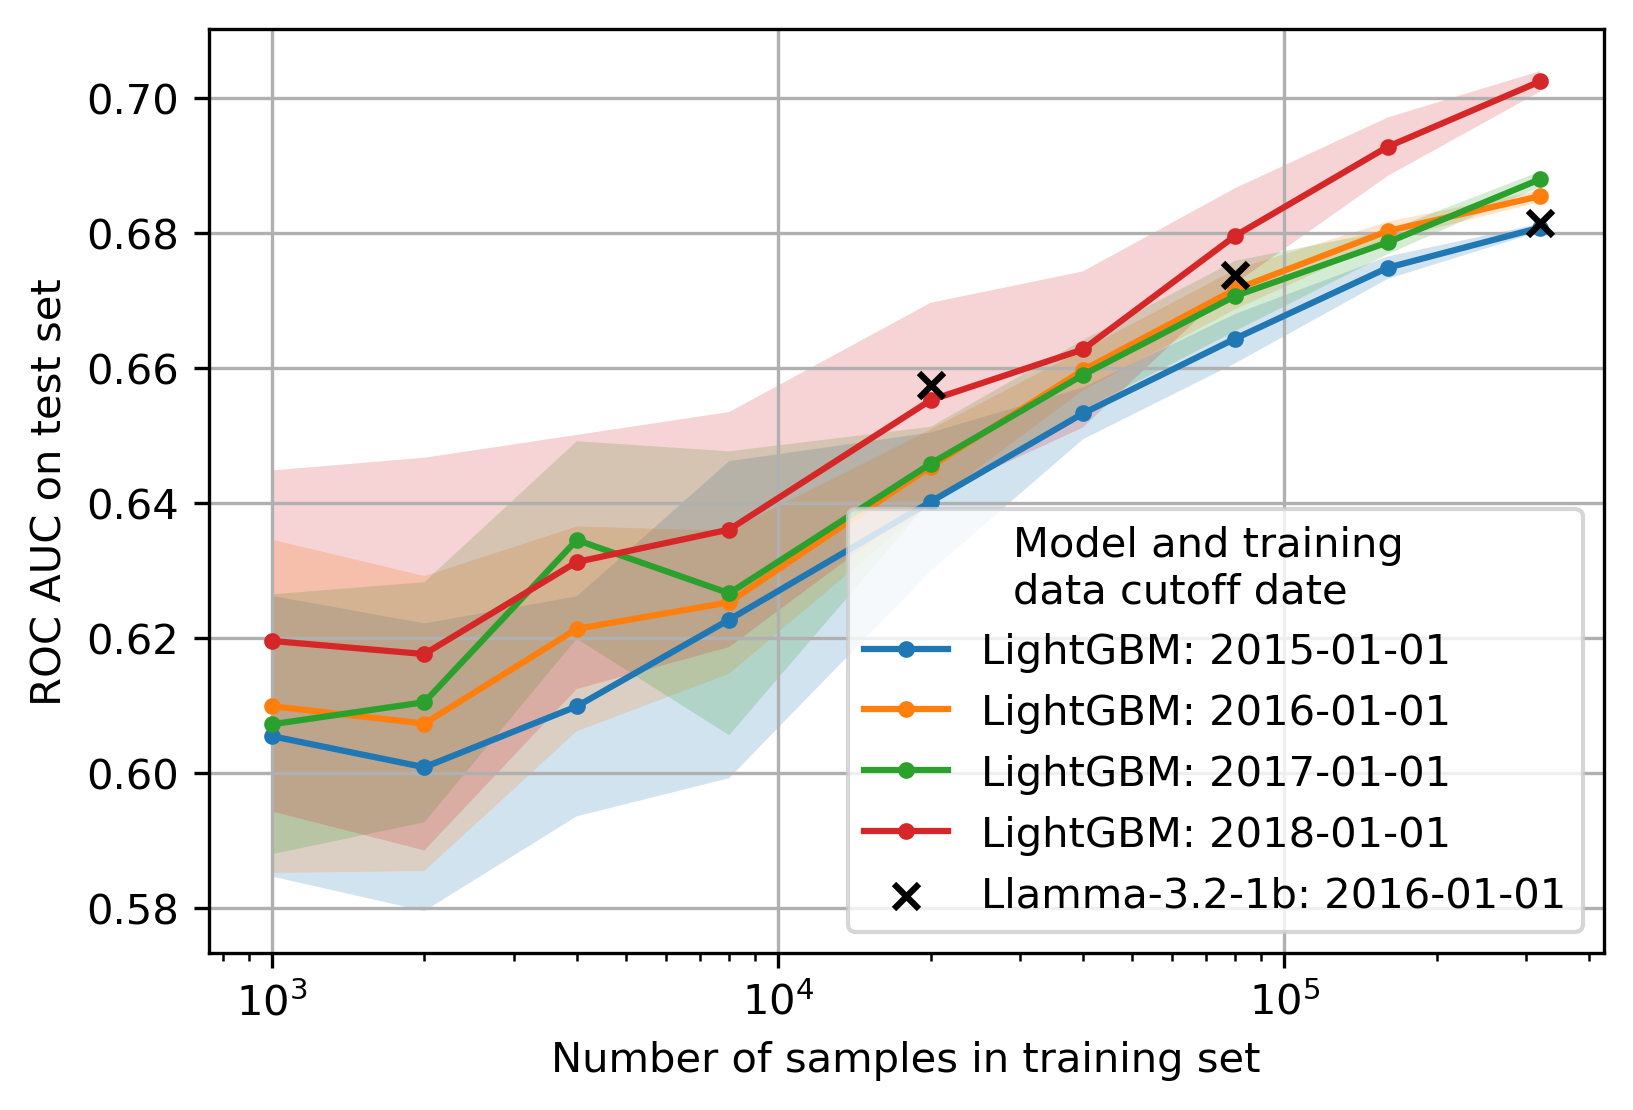

In [8]:
plt.figure(figsize=(6, 4), dpi=300)
# plot one line for each cutoff date
for cutoff_date in cutoff_dates:
    x = list(rocaucs[cutoff_date].keys())
    y = list(rocaucs[cutoff_date].values())
    y_std = list(std[cutoff_date].values())
    plt.plot(x, y, label='LightGBM: '+cutoff_date.strftime('%Y-%m-%d'), marker='o', markersize=3)
    plt.fill_between(x, np.array(y) - np.array(y_std), np.array(y) + np.array(y_std), alpha=0.2)

# add the llm results
for key in llm_results:
    plt.scatter(int(key), llm_results[key][0], color='black', marker='x', 
                label=f'Llamma-3.2-1b: 2016-01-01' if f'Llamma-3.2-1b: 2016-01-01' not in plt.gca().get_legend_handles_labels()[1] else "", 
                zorder=5)

plt.xscale('log')
plt.xlabel('Number of samples in training set')
plt.ylabel('ROC AUC on test set')
# plt.title('ROC AUC vs Number of samples')
plt.legend(title = 'Model and training \ndata cutoff date')
plt.grid()
# sns.despine()
plt.savefig('plots/roc_auc.pdf', bbox_inches='tight')


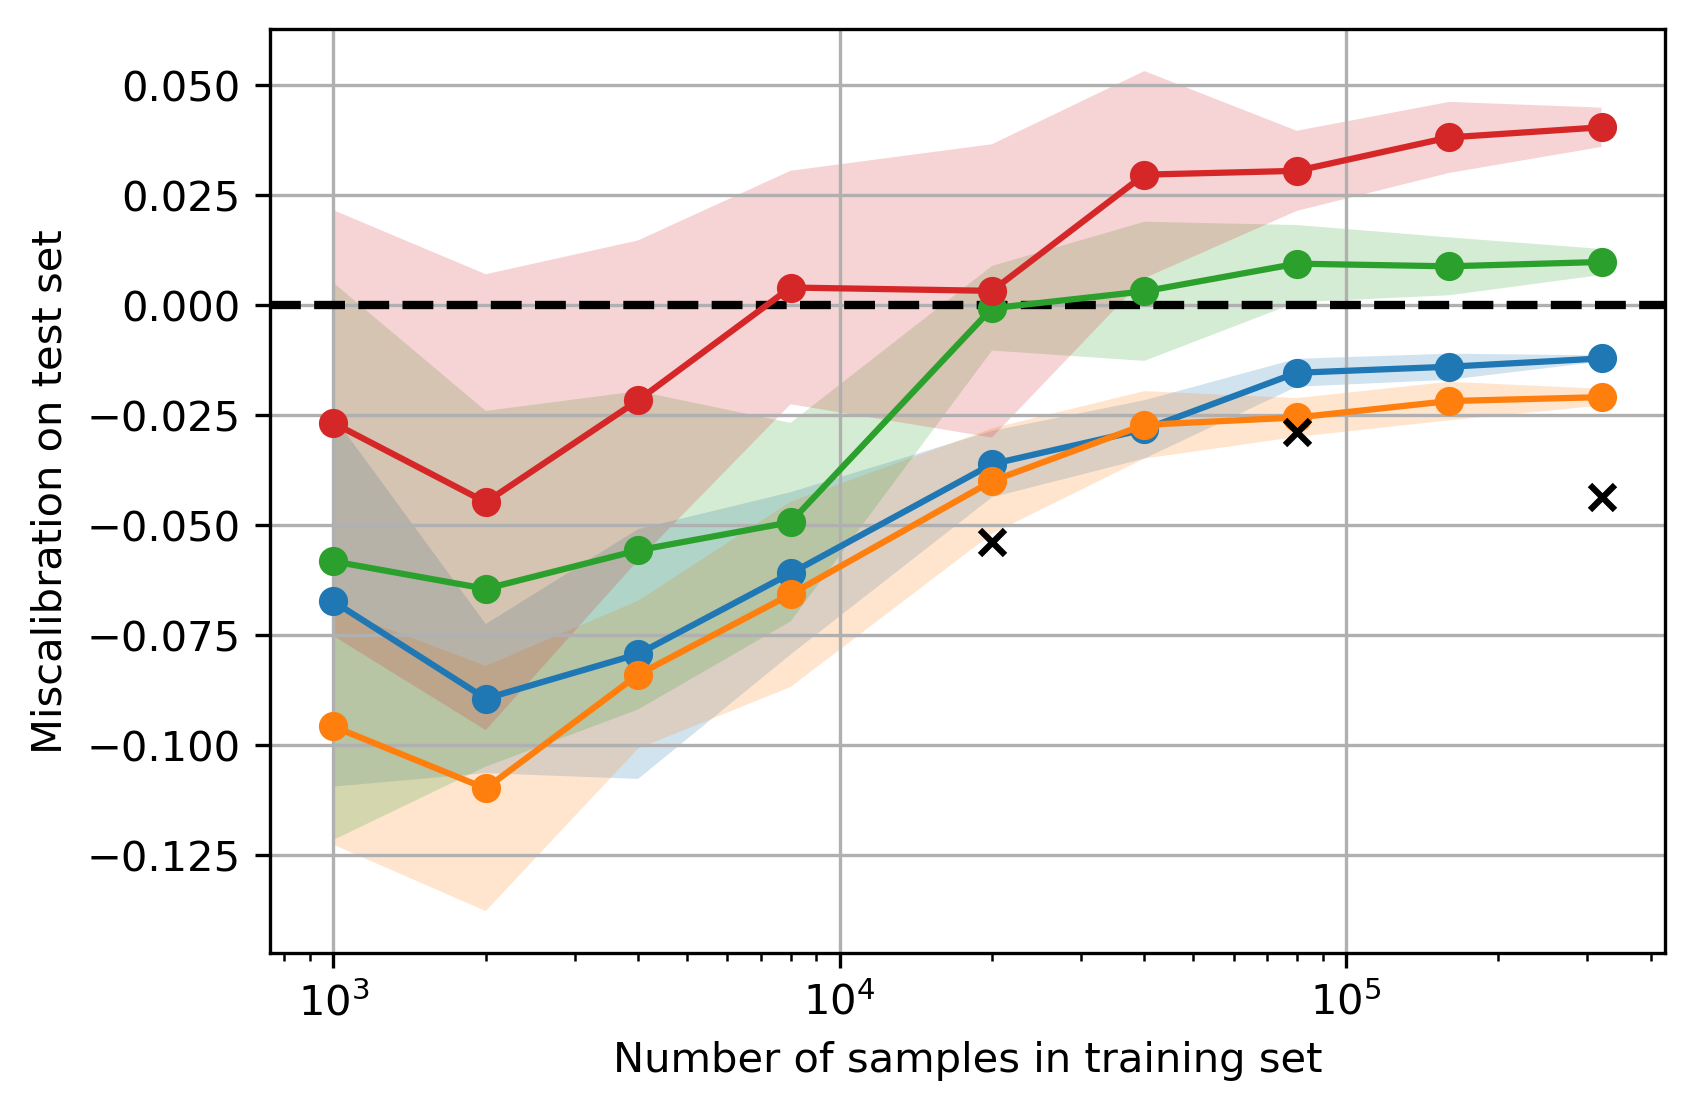

In [9]:
# similar plot for miscalibration
plt.figure(figsize=(6, 4), dpi=300)
plt.axhline(0, color='black', linestyle='--', linewidth=2)
# plot one line for each cutoff date
for cutoff_date in cutoff_dates:
    x = list(miscals[cutoff_date].keys())
    y = list(miscals[cutoff_date].values())
    y_std = list(miscals_std[cutoff_date].values())
    plt.plot(x, y, label='LightGBM: '+ cutoff_date.strftime('%Y-%m-%d'), marker='o')
    plt.fill_between(x, np.array(y) - np.array(y_std), np.array(y) + np.array(y_std), alpha=0.2)


# add the llm results
for key in llm_results:
    label = f'Llamma-3.2-1b: 2016-01-01'
    if label not in plt.gca().get_legend_handles_labels()[1]:
        plt.scatter(int(key), llm_results[key][1], color='black', marker='x', label=label, zorder=5)
    else:
        plt.scatter(int(key), llm_results[key][1], color='black', marker='x', zorder=5)

plt.xscale('log')
plt.xlabel('Number of samples in training set')
plt.ylabel('Miscalibration on test set')
# plt.title('Miscalibration vs Number of samples')
# plt.legend(title = 'Model and training \ndata cutoff date')
plt.grid()
plt.savefig('plots/miscalibration.pdf', dpi=300, bbox_inches='tight')
# plt.show()

In [10]:
# save the dictionary to a file
import pickle
with open('rocaucs.pkl', 'wb') as f:
    pickle.dump(rocaucs, f)
with open('std.pkl', 'wb') as f:
    pickle.dump(std, f)